# Image classification using CNN and pytorch

The goals of this notebook is to:
- Illustrate simple image classification using CNN implemeted by pytorch
- Illustrate visualization of metrics

The approach is similar to handgesture classification notebook.

## Loading the libraries

In [1]:
from keras.datasets import mnist
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


## Loading the data

The data can be loaded as already split between train and test sets. Data is loaded in the form of 28x28 images.

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))



Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


## Data inspection:

As usual check the shape of the train and test shape and since it is a classification check the distribution of the labels:

X_train shape: (60000, 28, 28)
Y_train_cat shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test_cat shape: (10000,)


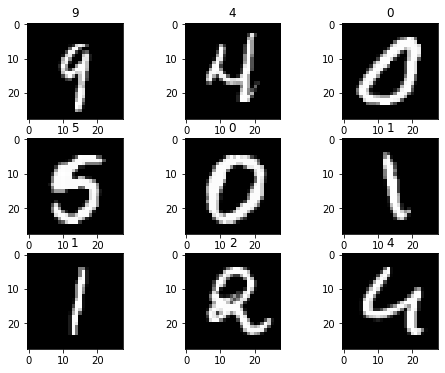

In [3]:
print ("X_train shape: " + str(trainX.shape))
print ("Y_train_cat shape: " + str(trainy.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test_cat shape: " + str(testy.shape))

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
for i in range(9):
    r = random.randint(0, trainX.shape[0])
    ax[i // 3, i % 3].imshow(trainX[r], cmap = 'gray')
    label = int(trainy[r])
    ax[i // 3, i % 3].set_title(label)

In [4]:
print("Ratio of number of each label to the entire data in the set:")
for i in range(10):
    count_train = np.where(trainy == i)[0]
    count_test = np.where(testy == i)[0]

    print("Label %d - train: %.2f - test: %.2f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Ratio of number of each label to the entire data in the set:
Label 0 - train: 0.10 - test: 0.10
Label 1 - train: 0.11 - test: 0.11
Label 2 - train: 0.10 - test: 0.10
Label 3 - train: 0.10 - test: 0.10
Label 4 - train: 0.10 - test: 0.10
Label 5 - train: 0.09 - test: 0.09
Label 6 - train: 0.10 - test: 0.10
Label 7 - train: 0.10 - test: 0.10
Label 8 - train: 0.10 - test: 0.10
Label 9 - train: 0.10 - test: 0.10


## Creating the model

First we build a simple two-layered NN with no regularization. Since it is a 10 class classification the loss function is simply the cross-entropy between logits (y_hat) and y (labels).

In [5]:
class FeedForward(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(FeedForward, self).__init__()
        self.FC_l1 = nn.Linear(input_dim, 32)
        self.FC_l2 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.tanh(self.FC_l1(x))
        y_hat = self.FC_l2(x)
        return y_hat
    
    def train(self, X, y, epochs, batch_size):
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        indices   = np.arange(X.shape[0])

        criterion = nn.CrossEntropyLoss()
        for i in range(epochs):
            optimizer.zero_grad()

            idx = indices[:batch_size]
            batch_X  = X[idx].reshape((batch_size, -1))
            batch_y  = y[idx]

            y_hat = self.forward(batch_X)

            loss = criterion(y_hat, batch_y)
            loss.backward()
            optimizer.step()
            
            if i % 500 == 0:
                print("Iteration is %d - loss: %.4f" %(i, loss))



    def test(self, test_data, test_labels, batch_size):
        k = 0
        all_probs = None
        while k < test_data.shape[0]:
            batch = test_data[k:k+batch_size,:,:] if k + batch_size <= test_data.shape[0] else test_data[k:,:,:]
            batch = batch.reshape((-1,test_data.shape[1]*test_data.shape[2]))
            logits = self.forward(batch)

            probs = F.softmax(logits, dim = 1).detach().numpy()

            all_probs = probs if all_probs is None else np.vstack((all_probs, probs))
            k += batch_size

        return all_probs

## Train the model

First we flatten the 28x28 images and then send them to the train method of the created model.

In [6]:
epochs = 10000
net = FeedForward(input_dim=(trainX.shape[1]*trainX.shape[2]), output_dim=10)

torch_trainX = torch.from_numpy(trainX).float()
torch_trainy = torch.from_numpy(trainy).long()
torch_testX = torch.from_numpy(testX).float()
torch_testy = torch.from_numpy(testy).long()

net.train(torch_trainX, torch_trainy, epochs = epochs, batch_size=64)

Iteration is 0 - loss: 2.5340
Iteration is 500 - loss: 0.1116
Iteration is 1000 - loss: 0.0420
Iteration is 1500 - loss: 0.0221
Iteration is 2000 - loss: 0.0134
Iteration is 2500 - loss: 0.0089
Iteration is 3000 - loss: 0.0062
Iteration is 3500 - loss: 0.0043
Iteration is 4000 - loss: 0.0032
Iteration is 4500 - loss: 0.0024
Iteration is 5000 - loss: 0.0018
Iteration is 5500 - loss: 0.0014
Iteration is 6000 - loss: 0.0010
Iteration is 6500 - loss: 0.0008
Iteration is 7000 - loss: 0.0006
Iteration is 7500 - loss: 0.0005
Iteration is 8000 - loss: 0.0004
Iteration is 8500 - loss: 0.0003
Iteration is 9000 - loss: 0.0002
Iteration is 9500 - loss: 0.0002


## Visualizing the result

The last softmax layer outputs the probability of each class. So we determine the class by taking the class with max probability.

Then we use sklearn to calculate the metrics of precision, recall by sending the true labels and predicted labels.

After that we calculate precision and recall for each class.


#### Train data set output

In [7]:
y_hat = net.test(torch_trainX, torch_trainy, batch_size=64)
preds = np.argmax(y_hat, axis=1)
precision, recall, _, _ = precision_recall_fscore_support(trainy, preds)
f1 = precision * recall / (precision + recall)
train_accuracy = metrics.accuracy_score(trainy, preds)
print(f"Accuracy on train data is {train_accuracy}")
print("Precision in each class:")

for i in range(precision.shape[0]):
    print("Label: %d - Precision: %.2f - Recall: %.2f - f1: %.2f"  %(i, precision[i], recall[i], f1[i]))

Accuracy on train data is 0.5867
Precision in each class:
Label: 0 - Precision: 0.57 - Recall: 0.87 - f1: 0.35
Label: 1 - Precision: 0.79 - Recall: 0.88 - f1: 0.42
Label: 2 - Precision: 0.58 - Recall: 0.46 - f1: 0.26
Label: 3 - Precision: 0.50 - Recall: 0.60 - f1: 0.27
Label: 4 - Precision: 0.53 - Recall: 0.68 - f1: 0.30
Label: 5 - Precision: 0.45 - Recall: 0.22 - f1: 0.15
Label: 6 - Precision: 0.75 - Recall: 0.67 - f1: 0.35
Label: 7 - Precision: 0.62 - Recall: 0.51 - f1: 0.28
Label: 8 - Precision: 0.57 - Recall: 0.43 - f1: 0.25
Label: 9 - Precision: 0.45 - Recall: 0.48 - f1: 0.23


#### Test data set output

In [8]:
y_hat = net.test(torch_testX, torch_testy, batch_size=64)
preds = np.argmax(y_hat, axis=1)
precision, recall, _, _ = precision_recall_fscore_support(testy, preds)
f1 = precision * recall / (precision + recall)
test_accuracy = metrics.accuracy_score(testy, preds)
print(f"Accuracy on test data is {train_accuracy}")
print("Precision in each class:")

for i in range(precision.shape[0]):
    print("Label: %d - Precision: %.2f - Recall: %.2f - f1: %.2f"  %(i, precision[i], recall[i], f1[i]))

Accuracy on test data is 0.5867
Precision in each class:
Label: 0 - Precision: 0.57 - Recall: 0.89 - f1: 0.35
Label: 1 - Precision: 0.81 - Recall: 0.88 - f1: 0.42
Label: 2 - Precision: 0.60 - Recall: 0.46 - f1: 0.26
Label: 3 - Precision: 0.50 - Recall: 0.64 - f1: 0.28
Label: 4 - Precision: 0.52 - Recall: 0.66 - f1: 0.29
Label: 5 - Precision: 0.41 - Recall: 0.19 - f1: 0.13
Label: 6 - Precision: 0.73 - Recall: 0.65 - f1: 0.34
Label: 7 - Precision: 0.61 - Recall: 0.52 - f1: 0.28
Label: 8 - Precision: 0.56 - Recall: 0.39 - f1: 0.23
Label: 9 - Precision: 0.43 - Recall: 0.46 - f1: 0.22


## ROC curve

We use sklearn to plot the ROC curve.
ROC curve is done in sklearn library by calculating th TPR and FPR for each thershold and plotting them agains each other: [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

<Figure size 432x288 with 0 Axes>

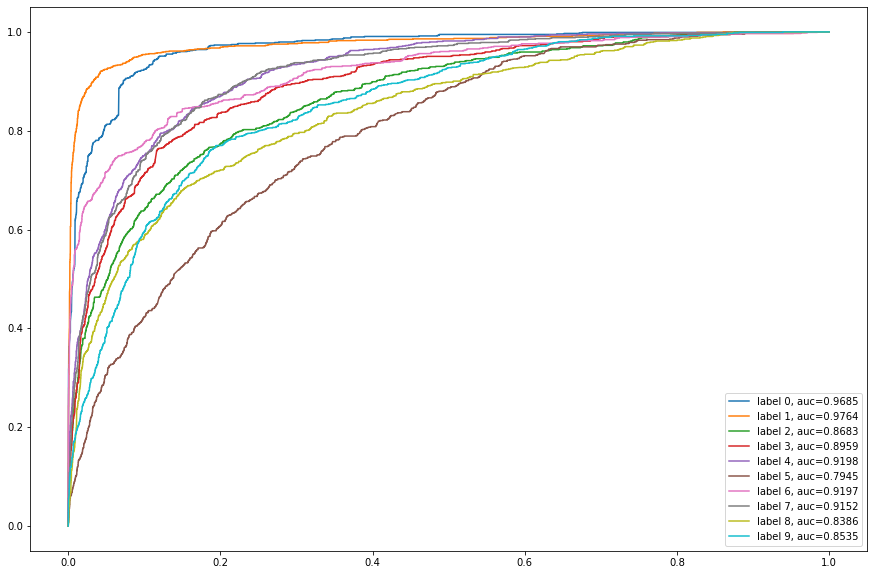

In [9]:
y = label_binarize(testy, classes=np.unique(testy))
plt.clf()
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    FPR, TPR, _ = metrics.roc_curve(y[:,i],  y_hat[:,i])
    AUC = metrics.roc_auc_score(y[:,i], y_hat[:,i])
    plt.plot(FPR,TPR,label="label %d, auc=%.4f" %(i, AUC))
plt.legend(loc=4)
plt.show()

## Confusion matrix

Confusion matrix can be plotted using the sklearn also. $C_{ij}$ in the confusion matrix is the number of samples in class i that have been predicted to be j. [Link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

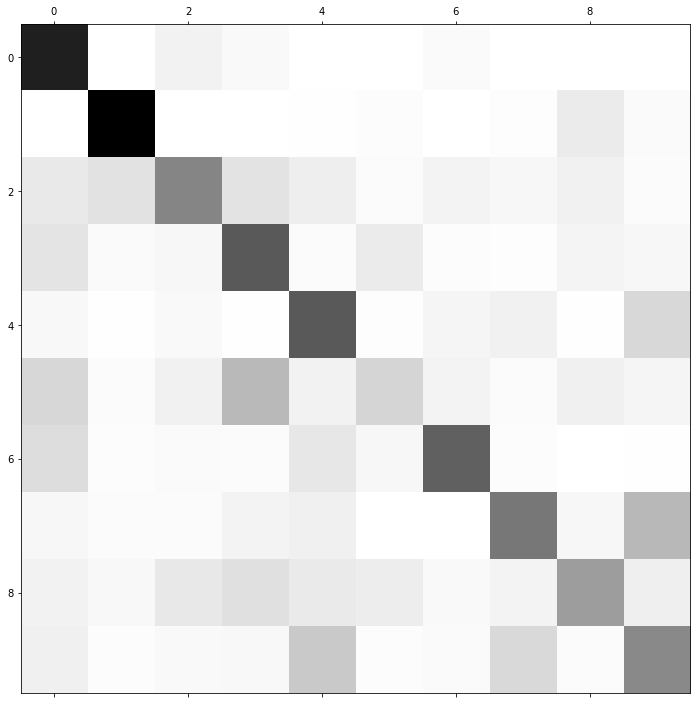

In [10]:
fig = plt.figure(figsize=(12, 12))
cm = metrics.confusion_matrix(testy, preds)
plt.matshow(cm, cmap='binary', fignum=1, aspect='auto')

Since the accuracy even on the train data set was not good (high bias) we build another model.

## Creating another model with CNN

The architecture of the CNN is Conv layer, Pooling layer, Conv layer, followed by 3 dense layers.

In [11]:
class CNN_network(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, X, y, epochs, batch_size):
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        indices = np.arange(X.shape[0])

        criterion = nn.CrossEntropyLoss()
        for i in range(epochs):
            optimizer.zero_grad()

            idx = indices[:batch_size]
            batch_data = X[idx]
            batch_label = y[idx]

            logits = self.forward(batch_data)

            loss = criterion(logits, batch_label)
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print("Iteration %d - loss: %.2f" %(i, loss))

    def test(self, test_data, test_labels, batch_size):
        k = 0
        all_probs = None
        while k < test_data.shape[0]:
            batch = test_data[k:k+batch_size,:,:] if k + batch_size <= test_data.shape[0] else test_data[k:,:,:]
            logits = self.forward(batch)

            probs = F.softmax(logits, dim = 1).detach().numpy()

            all_probs = probs if all_probs is None else np.vstack((all_probs, probs))
            k += batch_size

        return all_probs
        



## Train the model

In [12]:
net = CNN_network()

torch_trainX = torch.from_numpy(trainX).float()
torch_trainy = torch.from_numpy(trainy).long()
torch_testX = torch.from_numpy(testX).float()
torch_testy = torch.from_numpy(testy).long()

torch_trainX = torch.unsqueeze(torch_trainX, 1)
torch_testX = torch.unsqueeze(torch_testX, 1)

net.train(torch_trainX, torch_trainy, epochs = 2000, batch_size=128)

Iteration 0 - loss: 5.63
Iteration 500 - loss: 0.01
Iteration 1000 - loss: 0.00
Iteration 1500 - loss: 0.00


## Visualizing the result


Same analysis as before with ROC curve and confusion matrix but only on the test dataset.

In [13]:
y_hat = net.test(torch_testX, torch_testy, batch_size=64)
preds = np.argmax(y_hat, axis = 1)
precision, recall, _, _ = precision_recall_fscore_support(testy, preds)
f1 = precision * recall / (precision + recall)
accuracy = metrics.accuracy_score(torch_testy, preds)
print(f"Accuracy on test data is {accuracy}")
print("Precision in each class:")

for i in range(precision.shape[0]):
    print("Label: %d - Precision: %.4f - Recall: %.4f - f1: %.4f"  %(i, precision[i], recall[i], f1[i]))

Accuracy on test data is 0.7343
Precision in each class:
Label: 0 - Precision: 0.7528 - Recall: 0.9571 - f1: 0.4214
Label: 1 - Precision: 0.8130 - Recall: 0.9771 - f1: 0.4438
Label: 2 - Precision: 0.7133 - Recall: 0.7665 - f1: 0.3695
Label: 3 - Precision: 0.7286 - Recall: 0.7683 - f1: 0.3740
Label: 4 - Precision: 0.6908 - Recall: 0.8371 - f1: 0.3785
Label: 5 - Precision: 0.6925 - Recall: 0.2601 - f1: 0.1891
Label: 6 - Precision: 0.7641 - Recall: 0.7067 - f1: 0.3671
Label: 7 - Precision: 0.8908 - Recall: 0.7461 - f1: 0.4060
Label: 8 - Precision: 0.7996 - Recall: 0.4220 - f1: 0.2762
Label: 9 - Precision: 0.5734 - Recall: 0.8127 - f1: 0.3362


## New ROC curve

<Figure size 432x288 with 0 Axes>

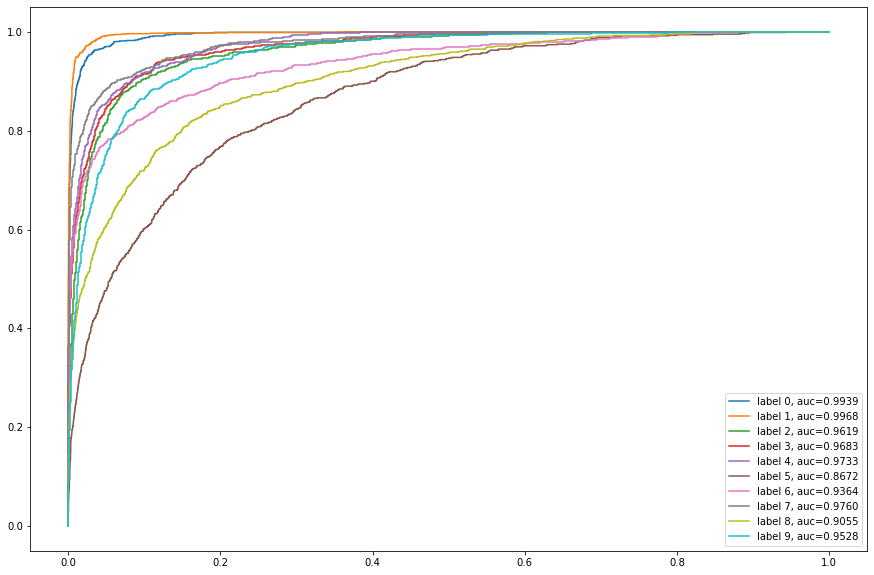

In [14]:
y = label_binarize(testy, classes=np.unique(testy))
plt.clf()
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    FPR, TPR, _ = metrics.roc_curve(y[:,i],  y_hat[:,i])
    AUC = metrics.roc_auc_score(y[:,i], y_hat[:,i])
    plt.plot(FPR,TPR,label="label %d, auc=%.4f" %(i, AUC))
plt.legend(loc=4)
plt.show()

# New confusion matrix

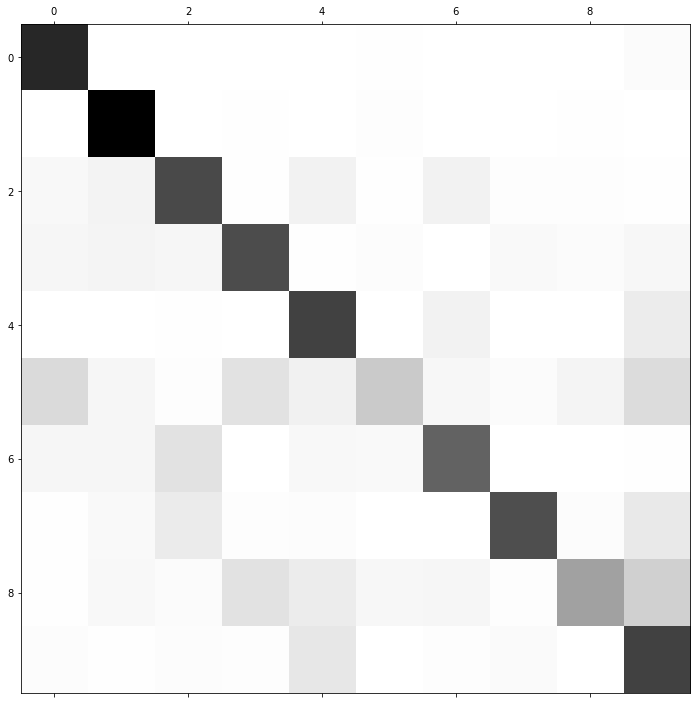

In [15]:
fig = plt.figure(figsize=(12, 12))
cm = metrics.confusion_matrix(testy, preds)
plt.matshow(cm, cmap='binary', fignum=1, aspect='auto')

## More analysis

The performance metrics have been improve but still there are some labels and class that cannot be easily distinguished. For example we can note from the above confusion matrix that there is a a lot of true labels 5 that are predicted to be 9.

We can try to find them and visualize them to see if there is a way to improve the model.

There are 152 number 5 that are labeled to be number 9. Some Examples are: 


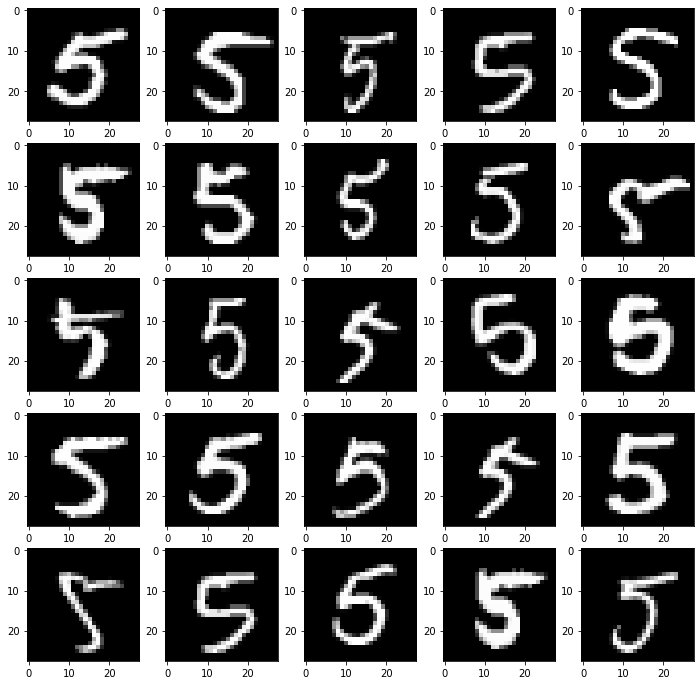

In [18]:
confused = []
for i in range(preds.shape[0]):
    if (preds[i] == 9 and testy[i] == 5):
        confused.append(testX[i])
        
print(f"There are {len(confused)} number 5 that are labeled to be number 9. Some Examples are: ")


fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i in range(25):
    r = random.randint(0, len(confused))
    ax[i // 5, i % 5].imshow(confused[r], cmap = 'gray')
    

Well, many of these can be correctly labeled by a human to be 5 and not 9 by mistake. So in theory it should be possible to improve the model.